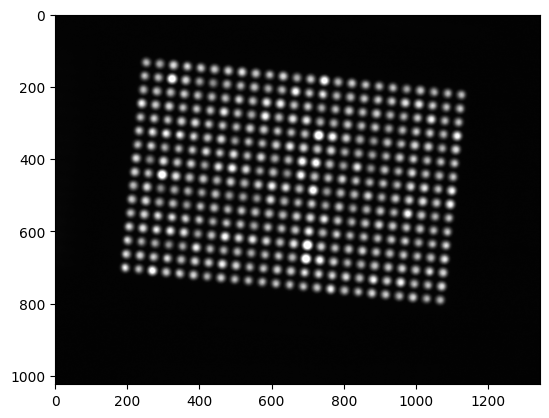

In [193]:
"""Load image"""

IMAGE_PATH = "/Users/antoinegerardin/Documents/data/rt-cetsa/Data for Nick/20210318 LDHA compound plates/20210318 LDHA compound plate 1 6K cells/1.tif"

from bfio import BioReader
from matplotlib import pyplot as plt

with BioReader(IMAGE_PATH) as br:
    bpp = br.bpp
    image = br[:].squeeze()
    plt.imshow(image, cmap='gray')



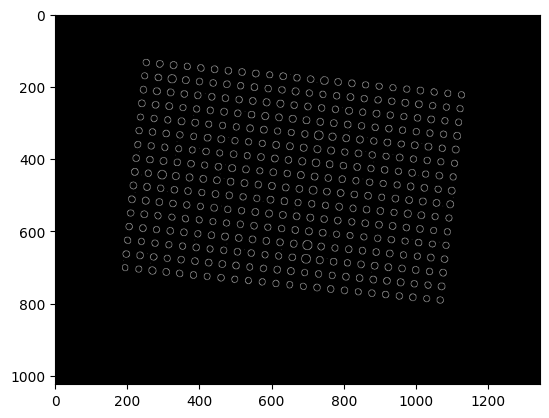

In [194]:
"""Extract wells from image"""

from skimage.feature import canny
from skimage.transform import hough_circle, hough_circle_peaks
import numpy as np

from skimage.draw import disk

def hough_transform_ovals(image):
    edges = canny(image, sigma=3, low_threshold=10, high_threshold=50)

    plt.imshow(edges, cmap='gray')
    plt.show()

    # TODO values are tied to the scale, not good
    hough_radii = np.arange(4, 20, 1)
    hough_res = hough_circle(edges, hough_radii)

    accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii, total_num_peaks=900)

    return (accums, cx, cy, radii)

accums, cx, cy, radii = hough_transform_ovals(image)


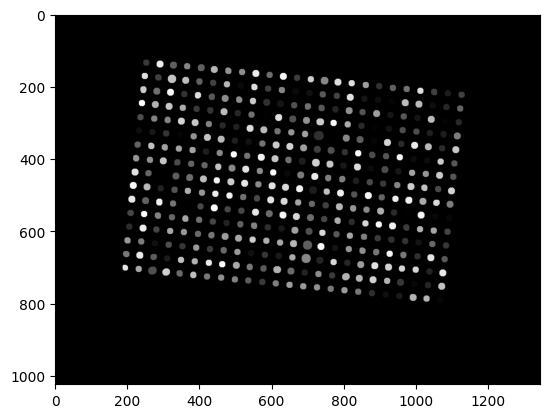

{0: (767, 339), 1: (296, 444), 2: (364, 528), 3: (581, 282), 4: (975, 552), 5: (885, 313), 6: (1078, 295), 7: (931, 241), 8: (345, 334), 9: (881, 351), 10: (1065, 791), 11: (993, 746), 12: (1089, 564), 13: (1051, 560), 14: (642, 441), 15: (665, 214), 16: (513, 198), 17: (873, 427), 18: (1029, 405), 19: (991, 401), 20: (1044, 253), 21: (893, 237), 22: (232, 322), 23: (914, 776), 24: (276, 634), 25: (542, 661), 26: (703, 218), 27: (923, 317), 28: (535, 353), 29: (1005, 632), 30: (774, 647), 31: (623, 248), 32: (1002, 287), 33: (855, 234), 34: (927, 279), 35: (949, 435), 36: (269, 326), 37: (797, 419), 38: (626, 593), 39: (952, 780), 40: (310, 676), 41: (618, 669), 42: (1086, 219), 43: (713, 487), 44: (683, 407), 45: (1074, 332), 46: (497, 350), 47: (417, 380), 48: (1036, 329), 49: (832, 461), 50: (501, 312), 51: (292, 482), 52: (474, 578), 53: (1035, 712), 54: (690, 715), 55: (775, 263), 56: (732, 681), 57: (1031, 750), 58: (808, 688), 59: (1082, 257), 60: (505, 274), 61: (1116, 299), 62

In [216]:
"""Create a mask by merging overlapping circles."""

well_index = {}

def create_labeled_mask(image, cy, cx, radii):
    mask = np.zeros(image.shape, dtype=int)
    id = 0

    for center_y, center_x, radius in zip(cy, cx, radii):
        rr, cc = disk((center_y, center_x), radius, shape=image.shape)
        if mask[center_y, center_x] != 0:
            mask[rr, cc] = mask[center_y, center_x]
        else:
            mask[rr, cc] = id
            well_index[id] = (center_x, center_y)
            id += 1
            
    return mask


mask = create_labeled_mask(image, cy, cx, radii)

plt.imshow(mask, cmap='gray')
plt.show()

assert len(well_index) == 384



print(well_index)

In [217]:
"""Estimate background correction."""

import math 

background = image - mask
background_value_1 = np.mean(background)
background_value_2 = np.ma.median(background)

cutoff = math.ceil(5 * np.prod(background.shape) / 100)
background_sorted = np.sort(background)
background_value_3 = background_sorted[:cutoff].mean()

print(f"background estimation :{background_value_1}, {background_value_2}, {background_value_3}")

background estimation :33202.556849888395, 32879.0, 33202.556849888395


In [218]:
"""Compute mean intensity for each well."""

background_value = background_value_2

unqID,idx,IDsums = np.unique(mask,return_counts=True,return_inverse=True)
values_sums = np.bincount(idx,image.ravel())
value_means = values_sums / IDsums 
value_means_corrected = value_means - background_value
object_index = {i:(IDsums[itr],value_means_corrected[itr]) for itr,i in enumerate(unqID) if i!=0}


print(np.min(unqID))
print(np.max(unqID))

# print(object_index[101])
# print(well_index[object_index[101][0]])



0
383


In [219]:
min_x = np.argmin(cx)
max_x = np.argmax(cx)
min_y = np.argmin(cy)
max_y = np.argmax(cy)

# TODO only work in this configuration! Certain orientations  would fail!

corners = [[cx[min_x],cy[min_x]], [cx[max_x],cy[max_x]], [cx[min_y],cy[min_y]], [cx[max_y],cy[max_y]]]

corners_top = sorted(corners , key=lambda c : c[1])
corners_left = sorted(corners , key=lambda c : c[0])

top_left, top_right = corners_top[0], corners_top[1]
top_left, bottom_left = corners_left[1], corners_left[0]



slope = (top_left[1] - top_right[1]) / (top_left[0] - top_right[0]);
angle = math.atan(slope)


width = math.sqrt((top_right[1] - top_left[1])**2 + (top_right[0] - top_left[0])**2)
print(f"width : {width}")

height = math.sqrt((top_left[1] - bottom_left[1])**2 + (top_left[0] - bottom_left[0])**2)
print(f"height : {height}")

print(f"rotation angle: {angle}")

width : 877.6269138990668
height : 569.066779912516
rotation angle: 0.10272986741866949


In [220]:
def rotate(origin, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle is in radians.
    """
    ox, oy = origin
    px, py = point

    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return qx, qy

well_index_rotated = {}
for key, (x,y) in well_index.items():
    well_index_rotated[key] = rotate(top_left, (x,y), angle)

well_index_rotated_translated = {}
for key, (x,y) in well_index_rotated.items():
    well_index_rotated_translated[key] = x - top_left[0], y - top_left[1]

well_coords = {}
for key, (x,y) in well_index_rotated_translated.items():
    col = math.floor(24 * x / width)
    row = math.floor(16 * y / height)
    well_coords[key] = (0 if col < 0 else col, 0 if row < 0 else row)

print(well_coords)

coords = [val for _, val in well_coords.items()]
coords = sorted(coords)

print(coords)

{0: (13, 7), 1: (0, 8), 2: (1, 11), 3: (8, 5), 4: (18, 13), 5: (16, 6), 6: (22, 6), 7: (18, 4), 8: (1, 5), 9: (16, 7), 10: (20, 20), 11: (18, 19), 12: (21, 14), 13: (20, 14), 14: (9, 9), 15: (11, 3), 16: (6, 2), 17: (16, 10), 18: (20, 9), 19: (19, 9), 20: (21, 5), 21: (17, 4), 22: (0, 5), 23: (16, 19), 24: (0, 14), 25: (6, 15), 26: (12, 3), 27: (17, 7), 28: (7, 6), 29: (19, 16), 30: (12, 15), 31: (9, 4), 32: (19, 6), 33: (16, 4), 34: (17, 6), 35: (18, 10), 36: (0, 5), 37: (14, 9), 38: (8, 13), 39: (17, 20), 40: (0, 15), 41: (8, 16), 42: (22, 4), 43: (11, 11), 44: (10, 8), 45: (21, 7), 46: (6, 6), 47: (3, 7), 48: (20, 7), 49: (14, 10), 50: (6, 5), 51: (0, 9), 52: (4, 13), 53: (19, 18), 54: (10, 17), 55: (13, 5), 56: (11, 16), 57: (19, 19), 58: (13, 17), 59: (22, 5), 60: (6, 4), 61: (23, 7), 62: (5, 5), 63: (15, 6), 64: (18, 8), 65: (21, 9), 66: (17, 13), 67: (14, 14), 68: (0, 12), 69: (7, 13), 70: (15, 19), 71: (18, 17), 72: (17, 15), 73: (12, 7), 74: (8, 4), 75: (14, 8), 76: (17, 3), 7

[[767 339]
 [296 444]
 [364 528]
 [581 282]
 [975 552]]
930
657


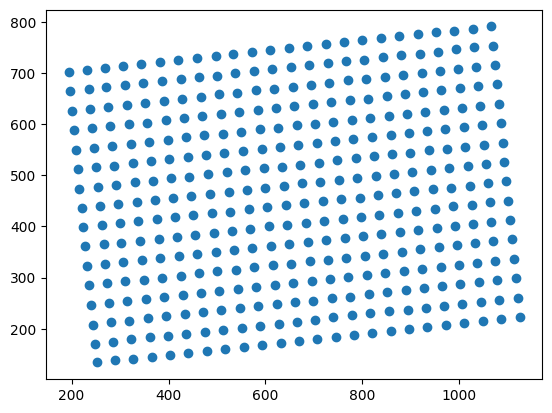

In [221]:
wells_centers = np.array([val for key, val in well_index.items()])
# print(wells_centers)
print(wells_centers[0:5])

max = np.max(wells_centers, axis=0)
min = np.min(wells_centers, axis=0)

width, height = max - min
print(width)
print(height)
#y
y = wells_centers[:,1]

#x
x = wells_centers[:,0]

plt.scatter(x,y)



[[ 797.72052214  258.55747631]
 [ 339.97134235  411.30461507]
 [ 416.22698007  487.88841046]
 [ 606.85581944  220.93214888]
 [1026.46692545  449.10427627]]


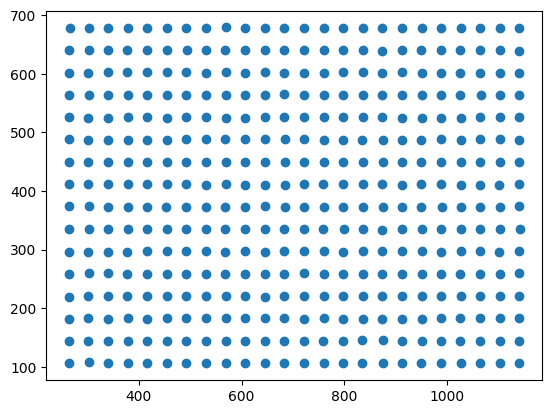

In [222]:
rotated_well_index = {key: rotate(origin=(0,0), point=wells_center, angle=-angle) for key, wells_center in well_index.items()}

rotated = np.array([val for val in rotated_well_index.values()])


print(rotated[0:5])

rotated = np.array(rotated)

y = rotated[:,1]

#x
x = rotated[:,0]

plt.scatter(x,y)

In [223]:
w = rotated
# print(w)

sorted_w = np.sort(w, axis=0)

# print(sorted_w)

w.shape
ordered = np.reshape(sorted_w, (48,-1,2))
print(ordered[0,:])

[[263.14142871 105.81033755]
 [263.46958638 105.82059247]
 [263.73621448 105.90263189]
 [263.79774405 106.06671072]
 [263.8182539  106.13849521]
 [263.96182288 106.22053463]
 [263.98233273 106.23078956]
 [264.0438623  106.30257405]]


In [226]:
rotated_wells = {(round(value[1]), round(value[0])): key for key,value in rotated_well_index.items()}
rotated_wells = sorted(rotated_wells.items(), key = lambda kv: kv[0][1])
# rotated_wells = sorted(rotated_wells.items(), key = lambda kv: kv[0][1])
# rotated_wells = sorted({(key[0], key[1]): value for key,value in rotated_wells.items()})

def divide_chunks(l, n): 
      
    # looping till length l 
    for i in range(0, len(l), n):  
        yield l[i:i + n] 

x = list(divide_chunks(rotated_wells, 16)) 

# for row in x:
#     print(row)

sorted_row_cols = []

for row in x:
    # print("row: ",  row)
    sorted_row = sorted(row, key = lambda kv: kv[0][0])
    sorted_row_cols.append(sorted_row)
    # print("sorted_row: ", sorted_row)

# print(sorted_row_cols)

min_val = 4000
for row in sorted_row_cols:
    for col in row:
        index = col[1]
        print(index)
        val = value_means_corrected[index]
        if val < min_val:
            min_val = val
        print(val)

print(min_val)

84
2249.853754940712
336
2302.5816733067695
302
2212.8327272727256
382
3058.566265060239
118
2333.8835341365484
22
2502.5179282868557
150
2281.5139442231084
223
2777.759541984735
340
2534.177419354841
373
2216.304918032787
347
2385.25566343042
106
2340.757692307692
68
2742.991967871487
228
2677.0705882352922
180
2679.076335877864
346
3022.7224880382782
356
2031.0
97
2303.185606060608
165
2305.9773462783196
264
2401.7409836065563
198
2538.3734939759015
36
2866.0677290836684
291
2578.4083969465646
215
1774.2142857142826
153
2360.808764940237
276
2712.4690553745895
144
2695.1488673139174
375
2723.040160642573
357
2762.9770491803283
185
2098.908366533862
350
2517.6051779935297
254
2292.522088353413
143
2658.3236245954686
293
3435.5995423340937
372
2270.8426229508186
299
2630.570491803279
197
2335.9045801526736
80
3132.8418972332
242
2096.301526717558
296
2798.1836065573734
1
3526.3386004514687
51
1714.084337349399
359
2085.024734982333
196
2686.5909090909117
103
2904.5140562249
24
2087.561